# LIMPIEZA

In [1]:
import pandas as pd
import numpy as np
import re


sheets = ["CENTRO","SUROESTE","NORTE","SUROESTE2","SURESTE3","NORESTE2"]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Compilación Datos no Limpios

In [24]:
import pandas as pd
from pathlib import Path

base = Path("/Users/gabrielvas/Desktop/Aplicacion_metodosmultivariados_Reto")
stations = ["CENTRO", "NORTE", "SUROESTE", "SUROESTE2", "SURESTE3", "NORESTE2"]
year_files = {
    2022: base / "DATOS_HISTORICOS_2022.xlsx",
    2023: base / "DATOS_HISTORICOS_2023.xlsx",
    2024: base / "DATOS_HISTORICOS_2024.xlsx",
    2025: base / "DATOS_HISTORICOS_2025.xlsx",
}

raw_series = {station: [] for station in stations}

columns_to_drop = ['RAINF', 'RH', 'PRS']

for year, file in year_files.items():
    yearly_raw = pd.read_excel(file, sheet_name=stations)  # sin limpieza
    for station in stations:
        df_station = yearly_raw[station].copy()
        # Eliminar columnas 'RAINF', 'RH', 'PRS' si existen
        df_station = df_station #.drop(columns=[col for col in columns_to_drop if col in df_station.columns], errors='ignore')
        df_station["date"] = pd.to_datetime(df_station["date"])
        df_station = df_station.set_index("date").sort_index()
        df_station["year"] = year           # opcional, ayuda a rastrear el origen
        raw_series[station].append(df_station)

df_por_estacion = {
    station: pd.concat(raw_series[station], axis=0)
    for station in stations
}

globals().update({
    f"df_{station}_22_25_nolimpio": df_por_estacion[station]
    for station in stations
})

# Ejemplo de verificación
for station in stations:
    print(station, df_por_estacion[station].shape)

CENTRO (30646, 16)
NORTE (30644, 16)
SUROESTE (30504, 16)
SUROESTE2 (30643, 16)
SURESTE3 (30643, 16)
NORESTE2 (30643, 16)


## Datos Limpios

### 2022

In [19]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2022.xlsx",
    sheet_name=sheets
)

# Remover columnas que no usarás
for name in sheets:
    raw_data[name] = raw_data[name] #.drop(columns=["RAINF","RH","PRS"])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 8),
    "NO": (0, 400),
    "NO2": (0, 175),
    "NOX": (0, 420),
    "O3": (0, 160),
    "PM10": (0, 999),
    "PM2.5": (0, 450),
    "SO2": (0, 200),
    "SR": (0, 1.25),
    "TOUT": (-5, 45),
    "WSR": (0, 35),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="spline", order=2)

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in sheets:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2022_{name}"] = temp_df

    print(f"Listo: df_2022_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2022_CENTRO creado (shape=(8760, 15))
Listo: df_2022_SUROESTE creado (shape=(8760, 15))
Listo: df_2022_NORTE creado (shape=(8760, 15))
Listo: df_2022_SUROESTE2 creado (shape=(8760, 15))
Listo: df_2022_SURESTE3 creado (shape=(8760, 15))
Listo: df_2022_NORESTE2 creado (shape=(8760, 15))

--- PROCESO COMPLETO ---


### 2023

In [20]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2023.xlsx",
    sheet_name=sheets
)

# Remover columnas que no usarás
for name in sheets:
    raw_data[name] = raw_data[name]#.drop(columns=["RAINF","RH","PRS"])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 14),
    "NO": (0, 500),
    "NO2": (0, 175),
    "NOX": (0, 500),
    "O3": (0, 175),
    "PM10": (0, 900),
    "PM2.5": (0, 800),
    "SO2": (0, 250),
    "SR": (0, 1),
    "TOUT": (0, 45),
    "WSR": (0, 40),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="spline", order=2)

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in sheets:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2023_{name}"] = temp_df

    print(f"Listo: df_2023_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2023_CENTRO creado (shape=(8758, 15))
Listo: df_2023_SUROESTE creado (shape=(8758, 15))
Listo: df_2023_NORTE creado (shape=(8758, 15))
Listo: df_2023_SUROESTE2 creado (shape=(8758, 15))
Listo: df_2023_SURESTE3 creado (shape=(8758, 15))
Listo: df_2023_NORESTE2 creado (shape=(8758, 15))

--- PROCESO COMPLETO ---


### 2024

In [21]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2024.xlsx",
    sheet_name=sheets
)

# Remover columnas que no usarás
for name in sheets:
    raw_data[name] = raw_data[name]#.drop(columns=["RAINF","RH","PRS"])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 18),
    "NO": (0, 400),
    "NO2": (0, 130),
    "NOX": (0, 500),
    "O3": (0, 180),
    "PM10": (0, 999),
    "PM2.5": (0, 999),
    "SO2": (0, 150),
    "SR": (0, 1.26),
    "TOUT": (-4, 45.5),
    "WSR": (0, 38),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="spline", order=2)

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in sheets:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2024_{name}"] = temp_df

    print(f"Listo: df_2024_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2024_CENTRO creado (shape=(8784, 15))
Listo: df_2024_SUROESTE creado (shape=(8784, 15))
Listo: df_2024_NORTE creado (shape=(8782, 15))
Listo: df_2024_SUROESTE2 creado (shape=(8782, 15))
Listo: df_2024_SURESTE3 creado (shape=(8782, 15))
Listo: df_2024_NORESTE2 creado (shape=(8782, 15))

--- PROCESO COMPLETO ---


### 2025

In [22]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2025.xlsx",
    sheet_name=sheets
)

# Remover columnas que no usarás
for name in sheets:
    raw_data[name] = raw_data[name]#.drop(columns=["RAINF","RH","PRS"])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 10),
    "NO": (0, 350),
    "NO2": (0, 175),
    "NOX": (0, 400),
    "O3": (0, 185),
    "PM10": (0, 820),
    "PM2.5": (0, 350),
    "SO2": (0, 405),
    "SR": (0, 1.2),
    "TOUT": (-4.5, 45),
    "WSR": (0, 40),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="spline", order=2)

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in sheets:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2025_{name}"] = temp_df

    print(f"Listo: df_2025_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")

Listo: df_2025_CENTRO creado (shape=(4344, 15))
Listo: df_2025_SUROESTE creado (shape=(4202, 15))
Listo: df_2025_NORTE creado (shape=(4344, 15))
Listo: df_2025_SUROESTE2 creado (shape=(4343, 15))
Listo: df_2025_SURESTE3 creado (shape=(4343, 15))
Listo: df_2025_NORESTE2 creado (shape=(4343, 15))

--- PROCESO COMPLETO ---


### Compilación Datos Limpiados

In [23]:
# Concatenar DataFrames por estación a través de 2022–2025

pattern = re.compile(r"^df_(2022|2023|2024|2025)_(.+)$")

frames_by_station: dict[str, list[tuple[int, pd.DataFrame]]] = {}
# Importante: iterar sobre una copia estática de globals() para evitar
# "RuntimeError: dictionary changed size during iteration"
for var_name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame):
        m = pattern.match(var_name)
        if m:
            year = int(m.group(1))
            station = m.group(2)
            frames_by_station.setdefault(station, []).append((year, obj))

combined_by_station: dict[str, pd.DataFrame] = {}
for station, items in frames_by_station.items():
    # Ordenar por año
    items_sorted = sorted(items, key=lambda x: x[0])
    frames = [df for _, df in items_sorted]

    # Alinear columnas (unión en el primer orden encontrado)
    ordered_union_cols: list[str] = []
    seen_cols: set[str] = set()
    for df in frames:
        for c in df.columns:
            if c not in seen_cols:
                seen_cols.add(c)
                ordered_union_cols.append(c)

    aligned_frames = [df.reindex(columns=ordered_union_cols) for df in frames]
    combined_df = pd.concat(aligned_frames, sort=False)
    combined_df = combined_df.sort_index()

    var_name = f"df_{station}_22_25"  # Nota: guiones no válidos en nombres de variables
    globals()[var_name] = combined_df
    combined_by_station[station] = combined_df

    print(f"Creado {var_name}: shape={combined_df.shape} | años={[y for y, _ in items_sorted]}")

# Acceso también vía diccionario
df_22_25_by_station = combined_by_station
print(f"\nEstaciones combinadas: {list(df_22_25_by_station.keys())}")


Creado df_CENTRO_22_25: shape=(30646, 15) | años=[2022, 2023, 2024, 2025]
Creado df_SUROESTE_22_25: shape=(30504, 15) | años=[2022, 2023, 2024, 2025]
Creado df_NORTE_22_25: shape=(30644, 15) | años=[2022, 2023, 2024, 2025]
Creado df_SUROESTE2_22_25: shape=(30643, 15) | años=[2022, 2023, 2024, 2025]
Creado df_SURESTE3_22_25: shape=(30643, 15) | años=[2022, 2023, 2024, 2025]
Creado df_NORESTE2_22_25: shape=(30643, 15) | años=[2022, 2023, 2024, 2025]

Estaciones combinadas: ['CENTRO', 'SUROESTE', 'NORTE', 'SUROESTE2', 'SURESTE3', 'NORESTE2']


## Análisis - CENTRO No Limpio

In [37]:
df = df_CENTRO_22_25_nolimpio.copy().drop(columns=["year"])
df.index = pd.to_datetime(df.index)

print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nRango temporal:", df.index.min(), "→", df.index.max())
df.info()
df.describe().T

Shape: (30646, 15)

Columnas: ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'PRS', 'RAINF', 'RH', 'SO2', 'SR', 'TOUT', 'WSR', 'WDR']

Rango temporal: 2022-01-01 00:00:00 → 2025-06-30 23:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30646 entries, 2022-01-01 00:00:00 to 2025-06-30 23:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      29974 non-null  float64
 1   NO      28710 non-null  float64
 2   NO2     29842 non-null  float64
 3   NOX     29843 non-null  float64
 4   O3      29453 non-null  float64
 5   PM10    29897 non-null  float64
 6   PM2.5   26630 non-null  float64
 7   PRS     30058 non-null  float64
 8   RAINF   30102 non-null  float64
 9   RH      29894 non-null  float64
 10  SO2     29120 non-null  float64
 11  SR      30318 non-null  float64
 12  TOUT    30096 non-null  float64
 13  WSR     30059 non-null  float64
 14  WDR     30077 non-null  float64
dtypes: float64(15)
memory usag

,count,mean,std,min,25%,50%,75%,max
CO,29974.0,1.589463,0.772967,0.050,1.010,1.450,2.0900,5.630
NO,28710.0,9.216778,13.622122,0.500,2.600,3.900,9.9000,288.400
NO2,29842.0,17.054306,11.281112,0.000,8.300,14.500,23.0000,97.900
NOX,29843.0,25.949941,21.701790,0.800,11.300,19.200,32.9000,362.800
O3,29453.0,28.892575,20.347773,1.000,13.000,25.000,40.0000,166.000
PM10,29897.0,60.804962,33.275909,2.000,39.000,53.000,74.0000,735.000
PM2.5,26630.0,24.184943,14.744236,2.000,13.840,20.870,31.0275,246.930
PRS,30058.0,711.383495,3.637774,682.400,709.100,711.200,713.5000,726.000
RAINF,30102.0,0.006570,0.680572,0.000,0.000,0.000,0.0000,83.450
RH,29894.0,54.000900,20.586351,1.000,38.000,55.000,71.0000,94.000


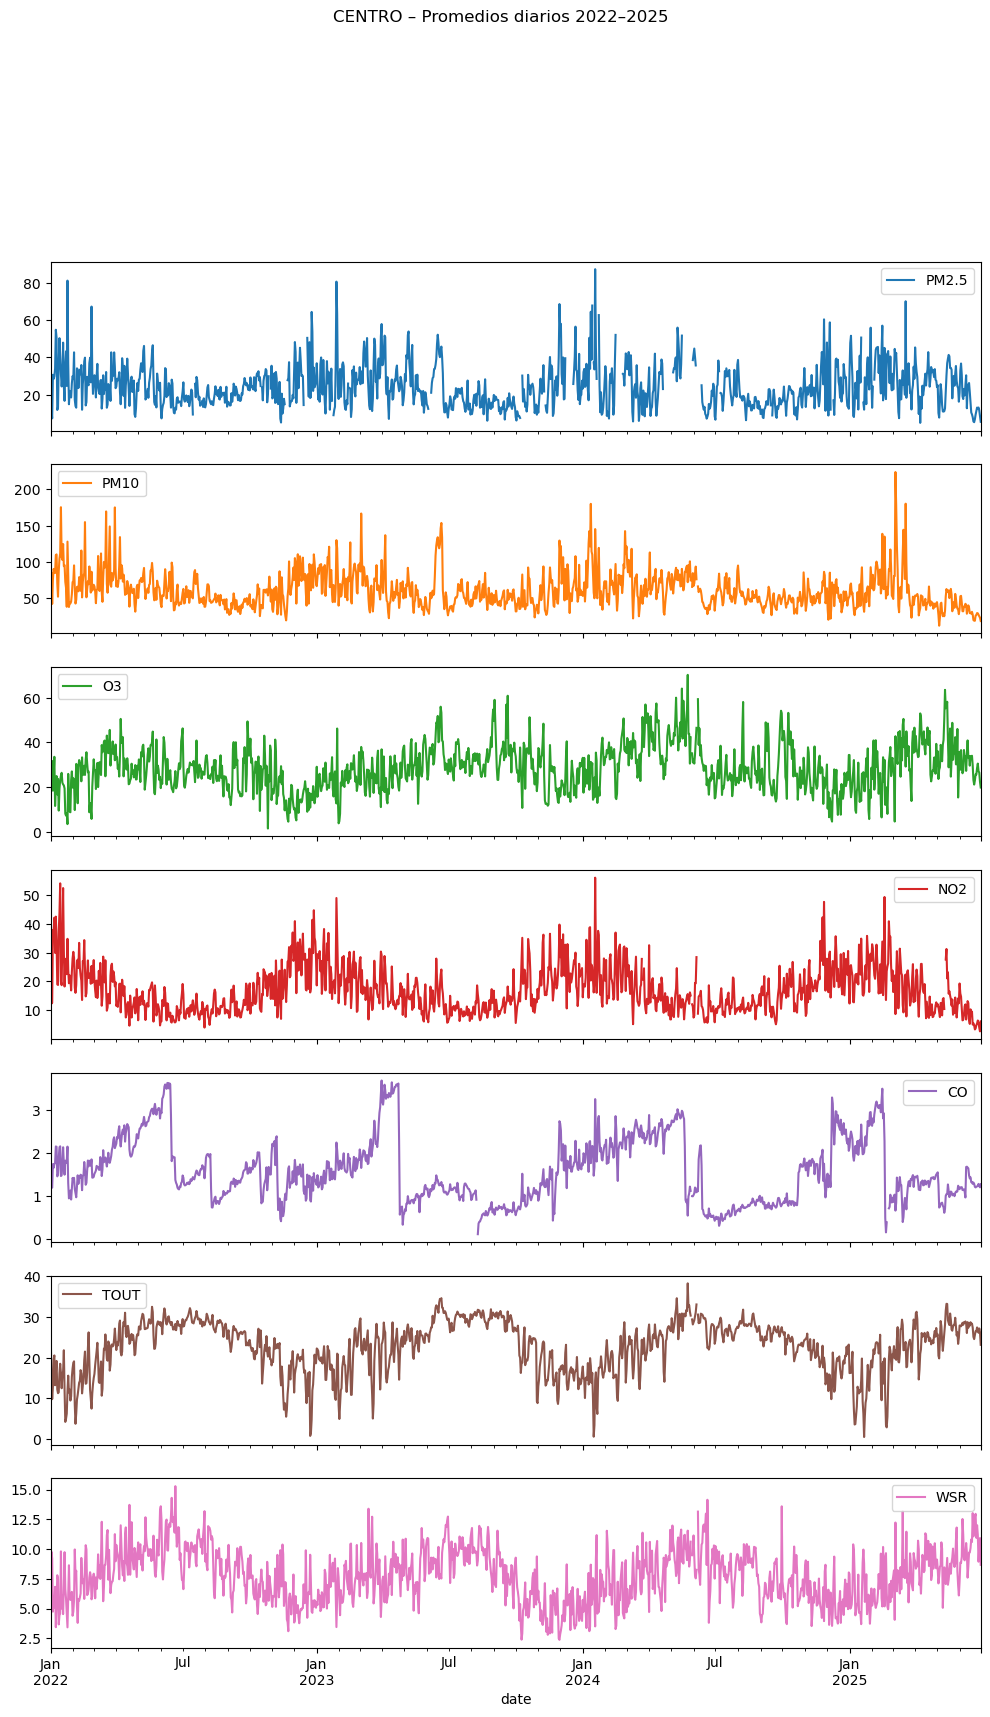

/var/folders/55/s6djj0fs7sz4wgdg619m7gy40000gn/T/ipykernel_65924/4010801535.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df.resample("M").mean()


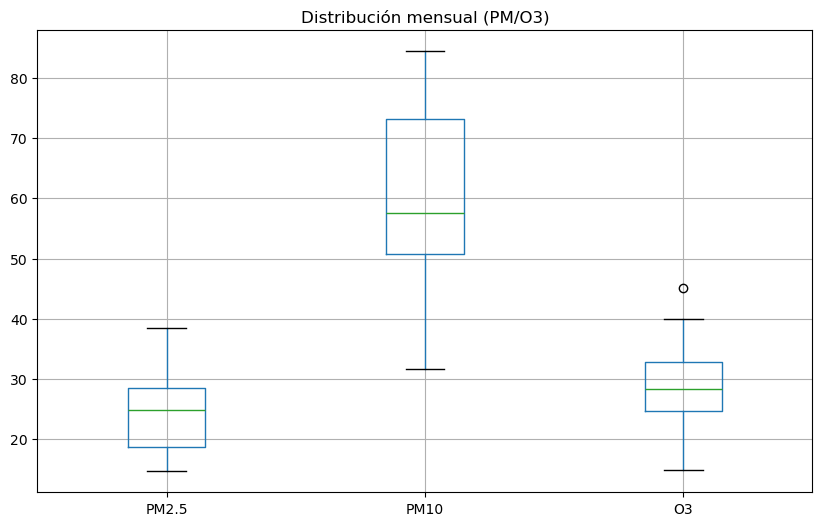

,PM2.5,PM10,O3,NO2,CO,TOUT,WSR
PM2.5,1.000000,0.653876,-0.028163,0.549273,0.373666,-0.085416,-0.237607
PM10,0.653876,1.000000,0.091461,0.474338,0.282237,0.013645,-0.061774
O3,-0.028163,0.091461,1.000000,-0.291479,-0.074298,0.520640,0.527678
NO2,0.549273,0.474338,-0.291479,1.000000,0.323854,-0.339066,-0.524191
CO,0.373666,0.282237,-0.074298,0.323854,1.000000,-0.156516,-0.129670
TOUT,-0.085416,0.013645,0.520640,-0.339066,-0.156516,1.000000,0.505275
WSR,-0.237607,-0.061774,0.527678,-0.524191,-0.129670,0.505275,1.000000


In [38]:
import matplotlib.pyplot as plt

cols_to_plot = ["PM2.5", "PM10", "O3", "NO2", "CO", "TOUT", "WSR"]
df[cols_to_plot].resample("D").mean().plot(subplots=True, figsize=(12, 18), sharex=True)
plt.suptitle("CENTRO – Promedios diarios 2022–2025", y=1.02)
plt.show()

# Estacionalidad resumida
monthly_stats = df.resample("M").mean()
monthly_stats.boxplot(column=["PM2.5", "PM10", "O3"], figsize=(10, 6))
plt.title("Distribución mensual (PM/O3)")
plt.show()

# Correlaciones básicas
corr = df.corr()
corr.loc[cols_to_plot, cols_to_plot]

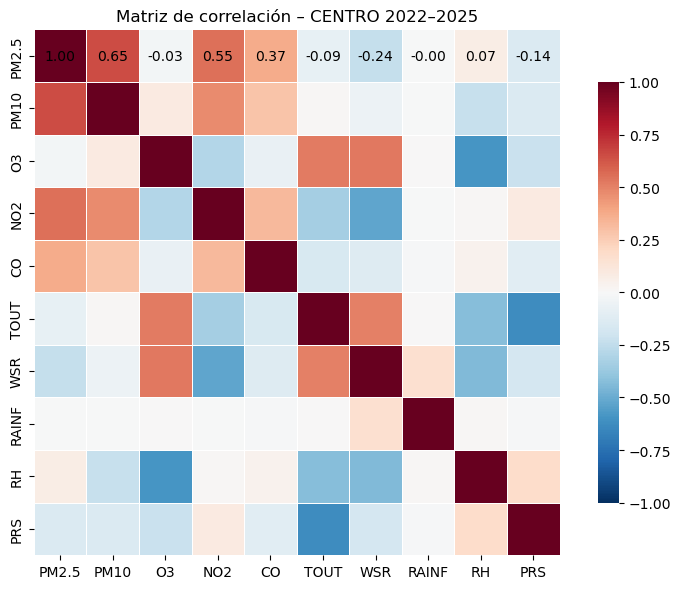

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["PM2.5", "PM10", "O3", "NO2", "CO", "TOUT", "WSR", "RAINF","RH","PRS"]
corr_subset = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_subset,
    annot=True,        # escribe el valor en cada celda
    fmt=".2f",         # dos decimales
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"color": "black", "fontsize": 10}  # opcional para legibilidad
)
plt.title("Matriz de correlación – CENTRO 2022–2025")
plt.tight_layout()
plt.show()

## Análisis - CENTRO

In [ ]:
df = df_CENTRO_22_25.copy()
df.index = pd.to_datetime(df.index)

print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nRango temporal:", df.index.min(), "→", df.index.max())
df.info()
df.describe().T

Shape: (30643, 15)

Columnas: ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'PRS', 'RAINF', 'RH', 'SO2', 'SR', 'TOUT', 'WSR', 'WDR']

Rango temporal: 2022-01-01 00:00:00 → 2025-06-30 23:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30643 entries, 2022-01-01 00:00:00 to 2025-06-30 23:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      30643 non-null  float64
 1   NO      30643 non-null  float64
 2   NO2     30643 non-null  float64
 3   NOX     30643 non-null  float64
 4   O3      30643 non-null  float64
 5   PM10    30643 non-null  float64
 6   PM2.5   30643 non-null  float64
 7   PRS     30643 non-null  float64
 8   RAINF   30643 non-null  float64
 9   RH      30643 non-null  float64
 10  SO2     30643 non-null  float64
 11  SR      30643 non-null  float64
 12  TOUT    30643 non-null  float64
 13  WSR     30643 non-null  float64
 14  WDR     30643 non-null  float64
dtypes: float64(15)
memory usag

,count,mean,std,min,25%,50%,75%,max
CO,30643.0,1.354034,0.815452,0.00,0.87,1.28,1.63,12.78
NO,30643.0,9.838645,20.208983,0.50,2.80,3.80,6.80,340.60
NO2,30643.0,11.170605,9.257337,0.00,4.80,7.80,14.50,85.00
NOX,30643.0,20.917870,26.667066,1.10,8.00,11.80,21.90,375.10
O3,30643.0,26.366201,16.653801,1.00,14.00,23.00,35.00,158.00
PM10,30643.0,68.328444,52.504911,2.00,38.00,55.00,80.00,757.00
PM2.5,30643.0,20.488268,19.552172,0.00,9.00,15.50,26.00,782.00
PRS,30643.0,728.318588,6.213610,685.50,723.15,728.70,732.40,750.00
RAINF,30643.0,0.001274,0.030429,0.00,0.00,0.00,0.00,3.11
RH,30643.0,59.676500,21.271995,1.00,43.00,62.00,78.00,94.00


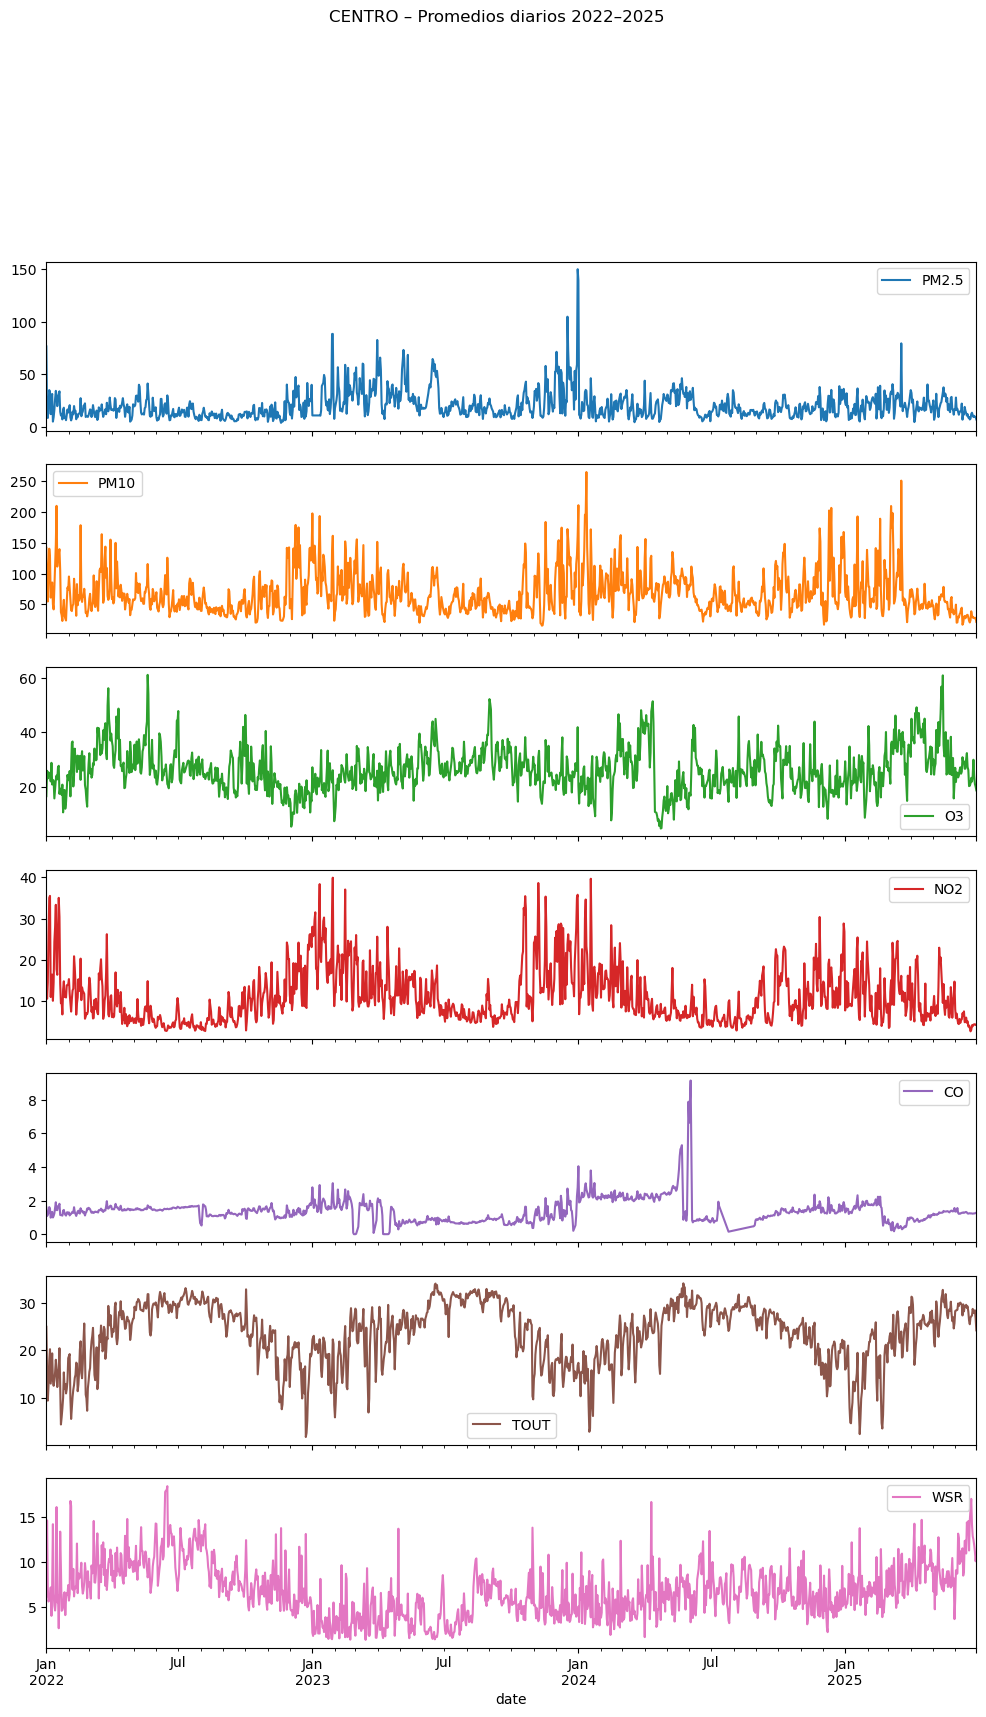

/var/folders/55/s6djj0fs7sz4wgdg619m7gy40000gn/T/ipykernel_65924/4010801535.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df.resample("M").mean()


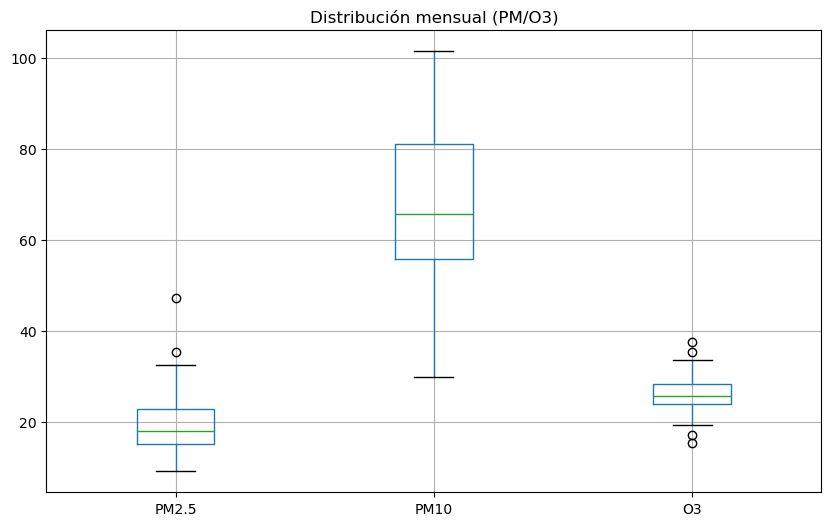

,PM2.5,PM10,O3,NO2,CO,TOUT,WSR
PM2.5,1.000000,0.601324,0.009384,0.433861,0.282873,0.049095,-0.218222
PM10,0.601324,1.000000,-0.103285,0.558091,0.357019,-0.036924,-0.093994
O3,0.009384,-0.103285,1.000000,-0.285503,-0.173693,0.450710,0.289334
NO2,0.433861,0.558091,-0.285503,1.000000,0.297632,-0.280624,-0.404462
CO,0.282873,0.357019,-0.173693,0.297632,1.000000,-0.116997,-0.085537
TOUT,0.049095,-0.036924,0.450710,-0.280624,-0.116997,1.000000,0.289712
WSR,-0.218222,-0.093994,0.289334,-0.404462,-0.085537,0.289712,1.000000


In [33]:
import matplotlib.pyplot as plt

cols_to_plot = ["PM2.5", "PM10", "O3", "NO2", "CO", "TOUT", "WSR"]
df[cols_to_plot].resample("D").mean().plot(subplots=True, figsize=(12, 18), sharex=True)
plt.suptitle("CENTRO – Promedios diarios 2022–2025", y=1.02)
plt.show()

# Estacionalidad resumida
monthly_stats = df.resample("M").mean()
monthly_stats.boxplot(column=["PM2.5", "PM10", "O3"], figsize=(10, 6))
plt.title("Distribución mensual (PM/O3)")
plt.show()

# Correlaciones básicas
corr = df.corr()
corr.loc[cols_to_plot, cols_to_plot]

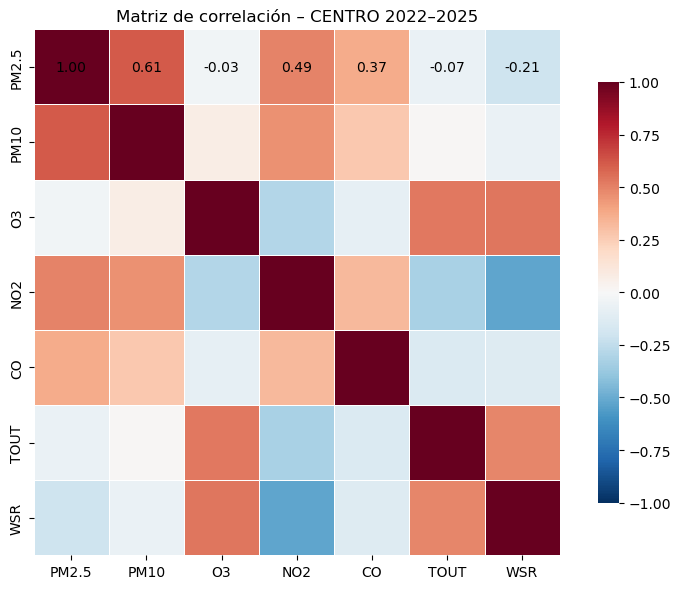

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["PM2.5", "PM10", "O3", "NO2", "CO", "TOUT", "WSR"]
corr_subset = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_subset,
    annot=True,        # escribe el valor en cada celda
    fmt=".2f",         # dos decimales
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"color": "black", "fontsize": 10}  # opcional para legibilidad
)
plt.title("Matriz de correlación – CENTRO 2022–2025")
plt.tight_layout()
plt.show()